In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ignore all warnings from the console
import warnings
warnings.filterwarnings('ignore')

In [17]:
# load data
data = pd.read_excel('consumption.xlsx')
data.describe()

id          Fresh          Milk       Grocery        Frozen  \
count  440.000000     440.000000    440.000000    440.000000    440.000000   
mean   220.500000   12000.297727   5796.265909   7951.277273   3071.931818   
std    127.161315   12647.328865   7380.377175   9503.162829   4854.673333   
min      1.000000       3.000000     55.000000      3.000000     25.000000   
25%    110.750000    3127.750000   1533.000000   2153.000000    742.250000   
50%    220.500000    8504.000000   3627.000000   4755.500000   1526.000000   
75%    330.250000   16933.750000   7190.250000  10655.750000   3554.250000   
max    440.000000  112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

In [18]:
print(data.isnull().sum())

id                  0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64


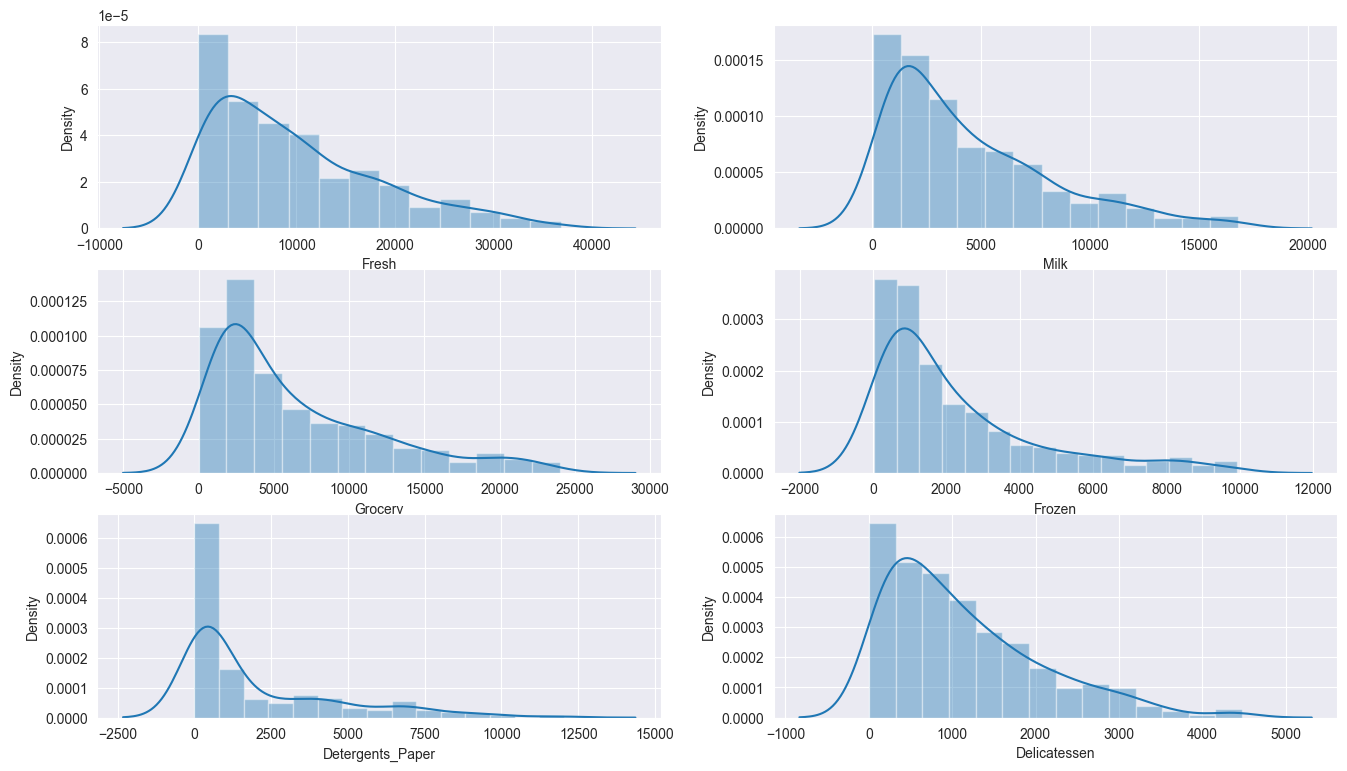

In [19]:
# plot the distribution of different attributes from the dataset

# prepare the canvas
fig = plt.figure(figsize=(16, 9))

# for each attribute plot its certain distribution
for i, col in enumerate(list(data.columns)[1:]):
    # add sub graph
    plt.subplot(321+i)
    # get the 95% point of data
    q95 = np.percentile(data[col], 95)
    # plot
    sns.distplot(data[data[col] < q95][col])
plt.show()

In [20]:
features = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']]

ids = []
# remove outliers
for i in list(features.columns):
    q1 = np.percentile(features[i], 25)
    q3 = np.percentile(features[i], 75)
    # determine an interval of the remaining data
    interval = 1.6 * (q3-q1) / 2
    # get the margin of data
    low = q1 - interval
    high = q3 +interval
    # get the id of data which don't lie in the interval
    ids.extend(list(features[(features[i] <= low) | (features[i] >= high)].index))
ids = list(set(ids))
# drop all the data which don't lie in the interval
features = features.drop(ids)

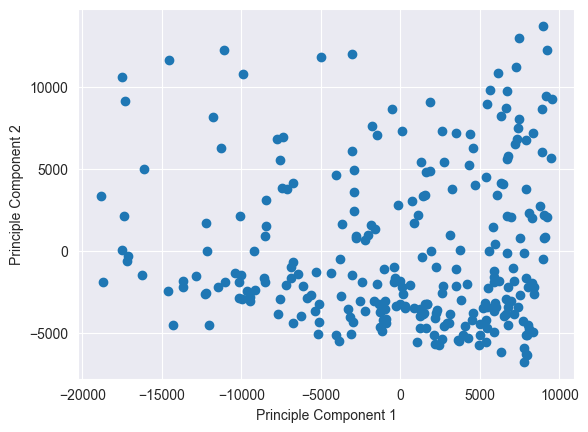

In [21]:
meandata = np.mean(features, axis=0)
stddata = np.std(features, axis=0)

# Normalization
features = features - meandata

# covariance matrix
cov = np.cov(features.transpose())
# get the eigen values and eigen vectors
eigval, eigvector = np.linalg.eig(cov)

# PCA
pca_mat = eigvector[:, :2]
pca_data = np.dot(features, pca_mat)
pca_data = pd.DataFrame(pca_data, columns=['pc1', 'pc2'])

# scatter plot
plt.subplot(111)
plt.scatter(pca_data['pc1'], pca_data['pc2'])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()

In [22]:
print('The information included in the first 2 PCs: {:.2%}'.format(np.sum(eigval[:2] / np.sum(eigval))))

The information included in the first 2 PCs: 92.39%


In [23]:
pca_data

pc1          pc2
0    -3049.808413  6056.974897
1     2648.325012  7305.393656
2     -123.803606  2794.756856
3    -2899.501154  2436.740191
4     1833.911607  4896.283646
..            ...          ...
264 -12187.957622   -18.408297
265   6618.069347 -3860.923418
266  -7412.412168  3820.819312
267  -1660.407847 -3044.654397
268   5876.693431 -3686.996818

[269 rows x 2 columns]

In [24]:
import matplotlib as mpl
# draw the trust region for the Gaussian Distribution
def make_ellipse(gmm, ax, k):
    for n in np.arange(k):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_shape[1]) * gmm.covariances_[n]

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)


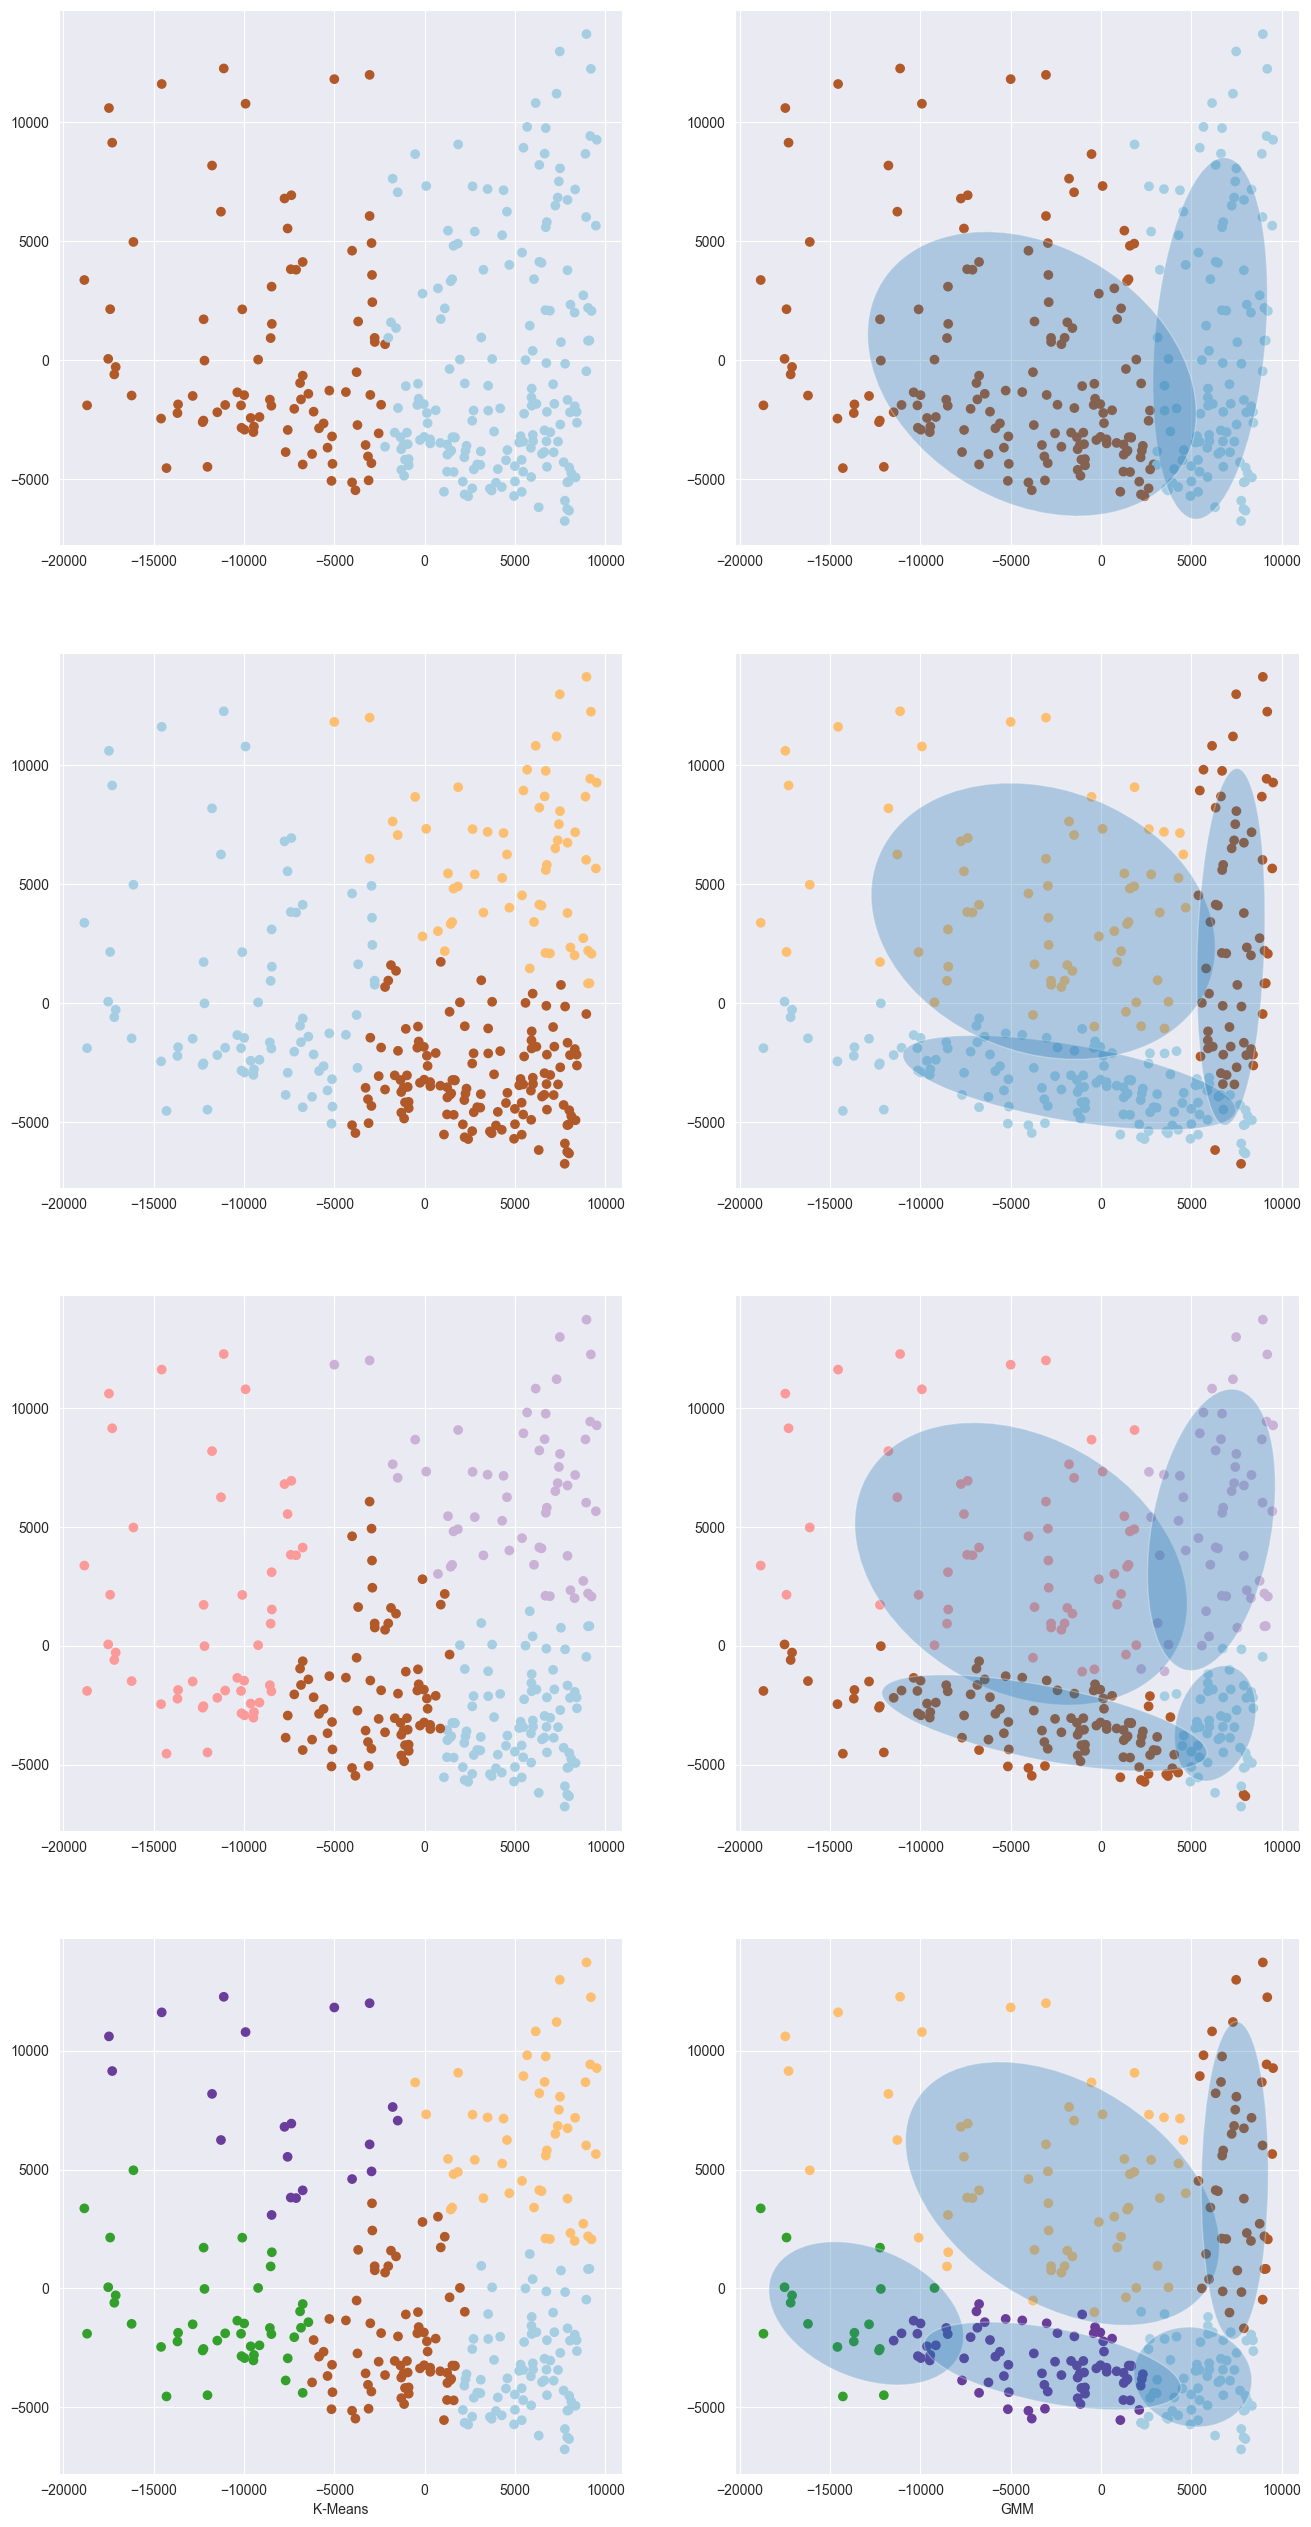

In [25]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

score_kmean = []
score_gmm = []
random_state = 666
n_cluster = np.arange(2, 6) # 2, 3, 4, 5
fig = plt.figure(figsize=(16, 32))

for i, k in zip([0, 2, 4, 6], n_cluster):
    # train K-Means Model
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster_1 = kmeans.fit_predict(pca_data)
    score_kmean.append(silhouette_score(pca_data, cluster_1))

    # train Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state)
    cluster_2 = gmm.fit(pca_data).predict(pca_data)
    score_gmm.append(silhouette_score(pca_data, cluster_2))

    # draw scatter plots and implement the clustering result inside
    ax = plt.subplot(421 + i)
    ax.scatter(pca_data['pc1'], pca_data['pc2'], c=cluster_1, cmap=plt.cm.Paired)
    if i == 6:
        ax.set_xlabel('K-Means')
    ax = plt.subplot(421+1+i)
    ax.scatter(pca_data['pc1'], pca_data['pc2'], c=cluster_2, cmap=plt.cm.Paired)
    make_ellipse(gmm, ax, k)
    if i == 6:
        ax.set_xlabel('GMM')
plt.show()

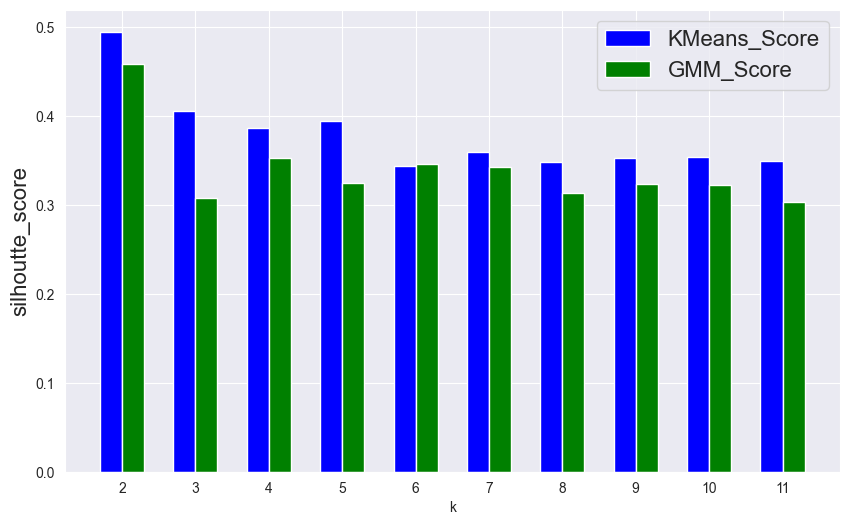

In [29]:
score_kmean = []
score_gmm = []
random_state = 666
n_cluster = np.arange(2, 12)
for k in n_cluster:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster_1 = kmeans.fit_predict(pca_data)
    score_kmean.append(silhouette_score(pca_data, cluster_1))

    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state)
    cluster_2 = gmm.fit(pca_data).predict(pca_data)
    score_gmm.append(silhouette_score(pca_data, cluster_2))

sil_core = pd.DataFrame({
    'k': np.arange(2, 12),
    'score_kmean': score_kmean,
    'score_gmm': score_gmm
})
# plot the silhoutte score for different number of components of different models
plt.figure(figsize=(10, 6))
plt.bar(sil_core['k'] - 0.15, sil_core['score_kmean'], width=0.3,
        facecolor='blue', label='KMeans_Score')
plt.bar(sil_core['k'] + 0.15, sil_core['score_gmm'], width=0.3,
        facecolor='green', label='GMM_Score')
plt.xticks(np.arange(2,12))
plt.legend(fontsize=16)
plt.ylabel('silhoutte_score', fontsize=16)
plt.xlabel('k')
plt.show()